# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [61]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy
from itertools import product

# Загружаем данные

И разделяем их на training и validation.

In [63]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/var/folders/8x/sy02cz7j5z3310hqp4hcxkgh0000gn/T/ipykernel_25275/2457508043.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/var/folders/8x/sy02cz7j5z3310hqp4hcxkgh0000gn/T/ipykernel_25275/2457508043.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_fla

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [64]:

# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [65]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [66]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for (0, 'W')
Gradient check passed!
Checking gradient for (0, 'B')
Gradient check passed!
Checking gradient for (2, 'W')
Gradient check passed!
Checking gradient for (2, 'B')
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [82]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for (0, 'W')
Gradient check passed!
Checking gradient for (0, 'B')
Gradient check passed!
Checking gradient for (2, 'W')
Gradient check passed!
Checking gradient for (2, 'B')
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [83]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.0

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [101]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 5e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.160388, Train accuracy: 0.251333, val accuracy: 0.276000
Loss: 1.892793, Train accuracy: 0.318222, val accuracy: 0.323000
Loss: 2.332145, Train accuracy: 0.362000, val accuracy: 0.376000
Loss: 2.367889, Train accuracy: 0.294222, val accuracy: 0.289000
Loss: 2.291995, Train accuracy: 0.285111, val accuracy: 0.322000
Loss: 2.196818, Train accuracy: 0.352556, val accuracy: 0.360000
Loss: 2.371195, Train accuracy: 0.307667, val accuracy: 0.325000
Loss: 2.300665, Train accuracy: 0.360111, val accuracy: 0.370000
Loss: 1.802364, Train accuracy: 0.336000, val accuracy: 0.342000
Loss: 2.135540, Train accuracy: 0.299556, val accuracy: 0.329000
Loss: 2.194567, Train accuracy: 0.289111, val accuracy: 0.299000
Loss: 2.018287, Train accuracy: 0.285667, val accuracy: 0.280000
Loss: 2.468541, Train accuracy: 0.189556, val accuracy: 0.200000
Loss: 2.412121, Train accuracy: 0.266556, val accuracy: 0.283000
Loss: 2.496081, Train accuracy: 0.293778, val accuracy: 0.281000
Loss: 2.350409, Train acc

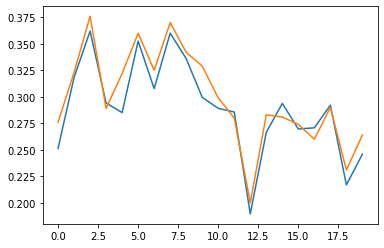

In [102]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [111]:

# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),  num_epochs=10, batch_size=100,
                  learning_rate=5e-1, learning_rate_decay=0.99)


initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.122190, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201423, Train accuracy: 0.251778, val accuracy: 0.256000
Loss: 2.131932, Train accuracy: 0.371000, val accuracy: 0.362000
Loss: 1.923996, Train accuracy: 0.430000, val accuracy: 0.415000
Loss: 1.915647, Train accuracy: 0.442556, val accuracy: 0.432000
Loss: 1.907117, Train accuracy: 0.521667, val accuracy: 0.511000
Loss: 2.066383, Train accuracy: 0.386111, val accuracy: 0.387000
Loss: 1.836315, Train accuracy: 0.509222, val accuracy: 0.516000
Loss: 2.060338, Train accuracy: 0.434889, val accuracy: 0.437000
Loss: 1.803606, Train accuracy: 0.545556, val accuracy: 0.575000


# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [117]:


model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(momentum=0.5), learning_rate=1e-1, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.146062, Train accuracy: 0.257333, val accuracy: 0.244000
Loss: 1.906655, Train accuracy: 0.425778, val accuracy: 0.445000
Loss: 1.635038, Train accuracy: 0.481444, val accuracy: 0.469000
Loss: 1.843154, Train accuracy: 0.524333, val accuracy: 0.526000
Loss: 1.914576, Train accuracy: 0.495778, val accuracy: 0.503000
Loss: 1.980458, Train accuracy: 0.498333, val accuracy: 0.511000
Loss: 1.800633, Train accuracy: 0.552556, val accuracy: 0.558000
Loss: 1.662761, Train accuracy: 0.520222, val accuracy: 0.531000
Loss: 2.118952, Train accuracy: 0.477444, val accuracy: 0.476000
Loss: 1.869553, Train accuracy: 0.535778, val accuracy: 0.542000
Loss: 2.003650, Train accuracy: 0.501111, val accuracy: 0.523000
Loss: 2.205309, Train accuracy: 0.552111, val accuracy: 0.548000
Loss: 2.127924, Train accuracy: 0.560889, val accuracy: 0.573000
Loss: 1.407775, Train accuracy: 0.536111, val accuracy: 0.544000
Loss: 2.320898, Train accuracy: 0.562778, val accuracy: 0.536000
Loss: 2.184488, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [119]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.318794, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.256573, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.290963, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.073704, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.329347, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.621465, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.717754, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.687888, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 1.546175, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.931788, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.822791, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.851774, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.892360, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.243815, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.503895, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.835122, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [133]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.291081, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.231431, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.237274, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.093766, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.353461, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.633088, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.792018, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.962871, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.826493, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.503490, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.710039, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.382539, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.577237, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.000287, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.732487, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 1.079172, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [147]:
# Let's train the best one-hidden-layer network we can

learning_rates = np.linspace(1e-1, 9e-1, 5)
reg_strength = np.linspace(1e-4, 1e-2, 3)
learning_rate_decay = np.logspace(-0.5, 0, 3)
hidden_layer_size = range(64, 128 + 1, 32)
optims = [SGD, MomentumSGD]
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []


# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

for lr, reg, lr_d, hls, optim in product(learning_rates, reg_strength, learning_rate_decay, hidden_layer_size, optims):
    optim = optim()
    model = TwoLayerNet(n_input = train_X.shape[1],
                        n_output = 10,
                        hidden_layer_size = hls,
                        reg = reg)
    dataset = Dataset(train_X[:data_size],
                      train_y[:data_size],
                      val_X[:data_size],
                      val_y[:data_size])
    trainer = Trainer(model, dataset, optim, learning_rate=lr, num_epochs=20, batch_size=5, verbose=False)
    l_history, t_history, v_history = trainer.fit()
    if best_val_accuracy is None or best_val_accuracy < v_history[-1]:
        best_val_accuracy = v_history[-1]
        best_classifier = model
        loss_history = l_history
        val_history = v_history
        train_history = t_history
    print('val acc: %.2e, lr: %.2e, reg: %.2e, hls: %d, optim: %s'%(v_history[-1], lr, reg, hls, optim))


print('best validation accuracy achieved: %f' % best_val_accuracy)

val acc: 6.67e-02, lr: 1.00e-01, reg: 1.00e-04, hls: 64, optim: <optim.SGD object at 0x7fdf728818b0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 64, optim: <optim.MomentumSGD object at 0x7fdf72881f40>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 96, optim: <optim.SGD object at 0x7fdf7298e8e0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 96, optim: <optim.MomentumSGD object at 0x7fdf72ad3040>
val acc: 6.67e-02, lr: 1.00e-01, reg: 1.00e-04, hls: 128, optim: <optim.SGD object at 0x7fdf72881fd0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 128, optim: <optim.MomentumSGD object at 0x7fdf72ad3370>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 64, optim: <optim.SGD object at 0x7fdf7298eaf0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 64, optim: <optim.MomentumSGD object at 0x7fdf72881fd0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 96, optim: <optim.SGD object at 0x7fdf7298eac0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-04, hls: 96, 

/Users/sashamalakhatka/Documents/ML/assignments/assignment2/layers.py:61: RuntimeWarning: divide by zero encountered in log
  loss = - np.log(probs[np.arange(len(probs)), target_index]).mean()


val acc: 6.67e-02, lr: 1.00e-01, reg: 1.00e-02, hls: 64, optim: <optim.MomentumSGD object at 0x7fdf6ebe6190>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-02, hls: 96, optim: <optim.SGD object at 0x7fdf72a41bb0>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-02, hls: 96, optim: <optim.MomentumSGD object at 0x7fdf7185c250>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-02, hls: 128, optim: <optim.SGD object at 0x7fdf6ab4dbb0>
val acc: 1.33e-01, lr: 1.00e-01, reg: 1.00e-02, hls: 128, optim: <optim.MomentumSGD object at 0x7fdf6ebe6190>
val acc: 6.67e-02, lr: 1.00e-01, reg: 1.00e-02, hls: 64, optim: <optim.SGD object at 0x7fdf72c27640>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-02, hls: 64, optim: <optim.MomentumSGD object at 0x7fdf7298ebb0>
val acc: 6.67e-02, lr: 1.00e-01, reg: 1.00e-02, hls: 96, optim: <optim.SGD object at 0x7fdf72a41a00>
val acc: 1.33e-01, lr: 1.00e-01, reg: 1.00e-02, hls: 96, optim: <optim.MomentumSGD object at 0x7fdf6ebe6190>
val acc: 0.00e+00, lr: 1.00e-01, reg: 1.00e-02, h

In [152]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-2)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.95)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.249359, Train accuracy: 0.230778, val accuracy: 0.237000
Loss: 1.920483, Train accuracy: 0.282556, val accuracy: 0.275000
Loss: 1.767418, Train accuracy: 0.395889, val accuracy: 0.400000
Loss: 1.611527, Train accuracy: 0.464111, val accuracy: 0.466000
Loss: 1.964847, Train accuracy: 0.549333, val accuracy: 0.560000
Loss: 1.819748, Train accuracy: 0.533889, val accuracy: 0.530000
Loss: 1.861451, Train accuracy: 0.586222, val accuracy: 0.591000
Loss: 1.916323, Train accuracy: 0.575556, val accuracy: 0.593000
Loss: 1.390807, Train accuracy: 0.583556, val accuracy: 0.595000
Loss: 2.110617, Train accuracy: 0.613778, val accuracy: 0.601000
Loss: 1.906599, Train accuracy: 0.606111, val accuracy: 0.600000
Loss: 1.843450, Train accuracy: 0.599333, val accuracy: 0.601000
Loss: 1.845467, Train accuracy: 0.634556, val accuracy: 0.627000
Loss: 1.810414, Train accuracy: 0.626889, val accuracy: 0.638000
Loss: 2.089466, Train accuracy: 0.652111, val accuracy: 0.636000
Loss: 1.672555, Train acc

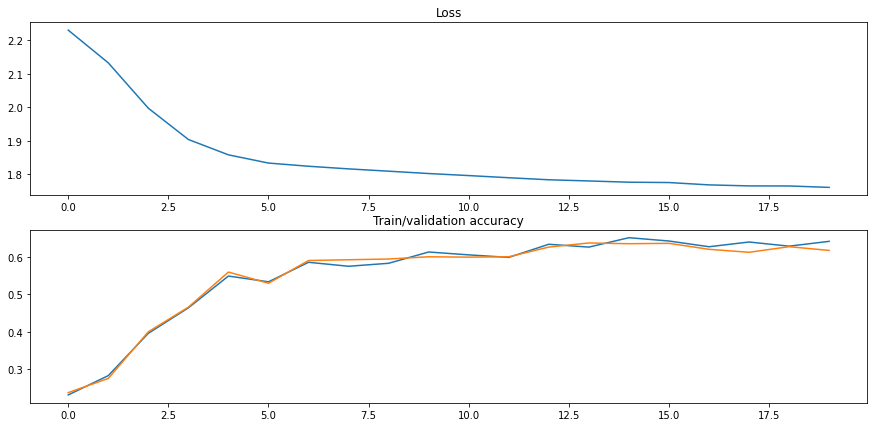

In [153]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [154]:
best_classifier = model

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [155]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.600000
